In [61]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [62]:
subICommets = pd.read_excel('Sub-I equity eval-comments-20230907.xlsx', 'Sub-I comments')

In [63]:
subICommets['Comment'].fillna('', inplace=True)

In [64]:
studentInfo = pd.read_excel('Sub-I equity eval-20231016.xlsx')
studentInfo = studentInfo.set_index('DEid')

In [65]:
print(studentInfo.columns.values)

['core_year' 'bridges_ind' 'gender' 'entry_year' 'isURM' 'race_ethnicity'
 'disadvantaged_ind' 'first_gen_ind_assoc' 'first_gen_ind_bach'
 'matchyear' 'match_inst' 'match_specialty' 'program' 'clinical_track'
 'graduated' 'grad_year' 'anes_site' 'fcm_site' 'med_site' 'neuro_site'
 'obgyn_site' 'peds_site' 'psych_site' 'surg_site' 'subi_site'
 'ec_exam_overall' 'mk_exam_overall' 'med_exam' 'neuro_exam' 'obgyn_exam'
 'peds_exam' 'psych_exam' 'surg_exam' 'anes_scale' 'fcm_scale' 'med_scale'
 'neuro_scale' 'obgyn_scale' 'peds_scale' 'psych_scale' 'surg_scale'
 'anes_grade' 'fcm_grade' 'med_grade' 'neuro_grade' 'obgyn_grade'
 'peds_grade' 'psych_grade' 'surg_grade' 'subinternship' 'subint_attresp'
 'subint_patfam' 'subint_fok' 'subint_hx' 'subint_oral' 'subint_phyexam'
 'subint_prb' 'subint_record' 'subint_selfimp' 'subint_relation'
 'subint_grade' 'aattresp' 'apatfam' 'afok' 'ahx' 'aoral' 'aphyexam'
 'aprb' 'arecord' 'aselfimp' 'arelation' 'fattresp' 'fpatfam' 'ffok' 'fhx'
 'foral' 'fphyex

In [66]:
# studentInfo['core_year'] = studentInfo['core_year'].astype(str)
def extract_end_year(year_range):
    if '-' in year_range:
        return int(year_range.split('-')[-1])
    else:
        return int(year_range)
# studentInfo['core_year'] = studentInfo['core_year'].apply(extract_end_year)

In [115]:
# studentInfo['core_year'] = studentInfo['core_year'].astype(int)

In [67]:
def getUIMNNonUIMComment(commentType):
    filteredComment = subICommets[(subICommets['Comment type']==commentType)]
    merged_Comment = filteredComment.merge(studentInfo, left_on='DeID', right_index=True, how='left')
    merged_Comment['core_year_y'] = merged_Comment['core_year_y'].astype(str)
    merged_Comment['core_year_y'] = merged_Comment['core_year_y'].apply(extract_end_year)
    merged_Comment['core_year_y'] = merged_Comment['core_year_y'].astype(int)
    filtered_df = merged_Comment[merged_Comment['core_year_y'].between(2019, 2021)]
    filtered_df['Comment'] = filtered_df['Comment'].str.lower()
    filtered_df['Comment'] = filtered_df['Comment'].str.replace(r"xx |xx\'s ", '', regex=True)
    
    UIM_Comment = filtered_df[(filtered_df['isURM']==1)]
    NonUIM_Comment = filtered_df[(filtered_df['isURM']==0)]
    return UIM_Comment, NonUIM_Comment

In [68]:
UIM_comment, NonUIM_comment = getUIMNNonUIMComment('Summary Comments')

/var/folders/lq/lnf_6ck55vzg7tq115d5x0bw0000gp/T/ipykernel_14673/4262509824.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Comment'] = filtered_df['Comment'].str.lower()
/var/folders/lq/lnf_6ck55vzg7tq115d5x0bw0000gp/T/ipykernel_14673/4262509824.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Comment'] = filtered_df['Comment'].str.replace(r"xx |xx\'s ", '', regex=True)


### Data Preprocessing (using nltk)

In [120]:
!pip install nltk


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [69]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
def lemmatize_document(doc):
    # Tokenize text and remove non-alphabetic characters
    tokens = nltk.word_tokenize(re.sub(r'[^a-zA-Z\s]', '', doc))
    # Lemmatize each word with its POS tag
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens])


[nltk_data] Downloading package wordnet to /Users/keshen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/keshen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/keshen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [70]:
removeWords = ["xx ", "xx's ", "he ", "she ", "his ", "her "]
pattern = '|'.join(removeWords)
UIM_comment['Comment'] = UIM_comment['Comment'].str.replace(pattern, '', regex=True)
NonUIM_comment['Comment'] = NonUIM_comment['Comment'].str.replace(pattern, '', regex=True)

UIM_comment['Comment'] = UIM_comment['Comment'].apply(lemmatize_document)
NonUIM_comment['Comment'] = NonUIM_comment['Comment'].apply(lemmatize_document)


In [71]:
print(UIM_comment['Comment'].to_list())

['take full ownership of patient and deliver excellent care to patient on tmedicine act internship tteam note that struck a great balance of confidence and humility in care conduct thorough history and examination impressed tteam with clear and concise presentation and ability to adjust presentation to tpace of round include comprehensive and accurate documentation in tmedical record include excellent preparation of draft discharge summary have a great fund of knowledge and it be clear be reading and integrate tread into care plan also demonstrate thoughtful synthesis of subjective and objective data into nuanced assessment and plan do a wonderful job identify primary active proble for patient a well a chronic issue demonstrate outstanding communication skill with patient family member and member of tmedical team take tinitiative to reach out to patient and family to provide update use patientcentered language attend note that be a very mature hardworking and motivate student who treat

### Feature Extraction (Embedding; using bert pretrained embedding)

In [72]:
import transformers
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [73]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Kmeans clustering, using bert embedding as features. PCA was employed to visualize the clustering results.

In [74]:
def clusteringComments(comments, nclusters=7):
    embeddings = []

    for doc in comments:
        inputs = tokenizer(doc, return_tensors='pt', truncation=True, max_length=512)
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy())

    embeddings = np.array(embeddings)

    kmeans = KMeans(n_clusters=nclusters)
    clusters = kmeans.fit_predict(embeddings)

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c=kmeans.labels_)
    plt.show()

    return kmeans, clusters


/Users/keshen/opt/anaconda3/envs/evenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


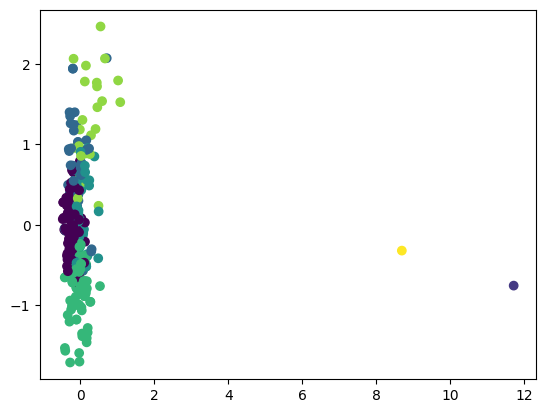

In [76]:
UIMmodel, UIMclusters = clusteringComments(UIM_comment['Comment'], 7)

/Users/keshen/opt/anaconda3/envs/evenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


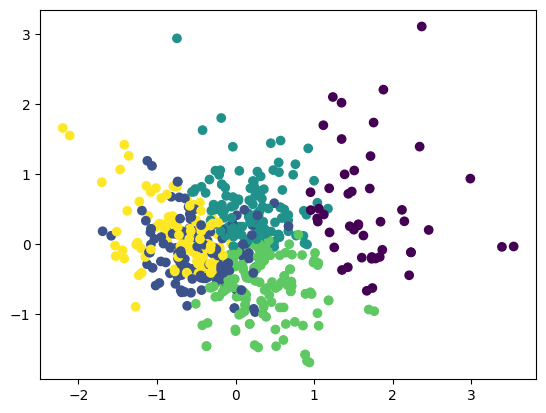

In [79]:
NonUIMmodel, NonUIMclusters = clusteringComments(NonUIM_comment['Comment'], 5)

In [80]:
### Cluster keywords:
clustered_docs = {i: [] for i in range(UIMmodel.n_clusters)}
for doc, cluster in zip(UIM_comment['Comment'].to_list(), UIMclusters):
    clustered_docs[cluster].append(doc)
for k in clustered_docs:
    print(k, clustered_docs[k][:3])  # skip cluster 2 and 6

0 ['take full ownership of patient and deliver excellent care to patient on tmedicine act internship tteam note that struck a great balance of confidence and humility in care conduct thorough history and examination impressed tteam with clear and concise presentation and ability to adjust presentation to tpace of round include comprehensive and accurate documentation in tmedical record include excellent preparation of draft discharge summary have a great fund of knowledge and it be clear be reading and integrate tread into care plan also demonstrate thoughtful synthesis of subjective and objective data into nuanced assessment and plan do a wonderful job identify primary active proble for patient a well a chronic issue demonstrate outstanding communication skill with patient family member and member of tmedical team take tinitiative to reach out to patient and family to provide update use patientcentered language attend note that be a very mature hardworking and motivate student who tre

In [81]:
### Cluster keywords:
Nonclustered_docs = {i: [] for i in range(NonUIMmodel.n_clusters)}
for doc, cluster in zip(NonUIM_comment['Comment'].to_list(), NonUIMclusters):
    Nonclustered_docs[cluster].append(doc)
for k in Nonclustered_docs:
    print(k, Nonclustered_docs[k][:3])

0 ['developed thoughtful plan that demonstrate a depth of knowledge and a strong grasp of tkey factor in a patient hospital course during act internship in internal medicine be routinely care for extremely complicate patient on a busy medicine service go above and beyond for patient and will be a fantastic intern be extremely organize conscientious and hardworking have a strong knowledge base thoughtfully conxxered patient issue and be constantly look up new information to well care for patient come back to tgroup with inform decision for patient managementwas an outstanding communicator and be constantly advocate for patient really shine when it come to professionalism be completely dedicate to patient and their clinical outcome work well with all on team and otmembers of tinterprofessional staff be very efficient and able to prioritize task be a very independent subintern and be function at an intern level', 'developed thoughtful plan that demonstrate a depth of knowledge and a stron

In [82]:
"""  UIM keywords  """

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
UIM_tfidf_matrix = tfidf_vectorizer.fit_transform(UIM_comment['Comment'].to_list())
UIM_feature_names = tfidf_vectorizer.get_feature_names_out()

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
UIMtf_matrix = vectorizer.fit_transform(UIM_comment['Comment'].to_list())
UIMtffeature_names = vectorizer.get_feature_names_out()

In [115]:
def get_top_keywords_for_cluster(cluster_id, n_terms, clusters, tfidf_matrix, feature_names):
    docs_indices = [i for i, c in enumerate(clusters) if c == cluster_id]
    
    aggregated_tfidf = np.mean(tfidf_matrix[docs_indices].toarray(), axis=0)
    
    sorted_indices = np.argsort(aggregated_tfidf)[::-1]  # Sort in descending order
    top_terms = [feature_names[i] for i in sorted_indices[:n_terms]]
    return top_terms

UIMTerms = set(list([]))
for i in range(UIMmodel.n_clusters):
    if i != 6 and i != 1:
        top_terms = get_top_keywords_for_cluster(i, 100, UIMclusters, UIM_tfidf_matrix, UIM_feature_names)
        UIMTerms.update(top_terms)
        print(f"Cluster {i}: {top_terms}")
print(len(list(UIMTerms)), UIMTerms)

Cluster 0: ['patient', 'care', 'able', 'plan', 'task', 'tteam', 'team', 'knowledge', 'great', 'note', 'medical', 'identify', 'student', 'information', 'work', 'member', 'excellent', 'feedback', 'complete', 'medicine', 'thorough', 'skill', 'history', 'outstanding', 'family', 'help', 'learn', 'presentation', 'communicate', 'demonstrate', 'base', 'clinical', 'question', 'consultant', 'complex', 'independently', 'ask', 'communication', 'clear', 'round', 'new', 'act', 'make', 'professional', 'job', 'displayed', 'internship', 'differential', 'diagnosis', 'multiple', 'need', 'ensure', 'extremely', 'understand', 'concise', 'organize', 'thoughtful', 'advocate', 'discharge', 'time', 'proble', 'rotation', 'prioritize', 'physical', 'incorporate', 'clearly', 'reliable', 'manner', 'follow', 'reason', 'intern', 'accurate', 'level', 'ability', 'assessment', 'relevant', 'doctor', 'treatment', 'function', 'update', 'actively', 'day', 'way', 'use', 'include', 'rexxent', 'advanced', 'integrate', 'data', '

In [85]:
"""  NonUIM keywords  """

from sklearn.feature_extraction.text import TfidfVectorizer

Nontfidf_vectorizer = TfidfVectorizer(stop_words='english')
Nontfidf_matrix = tfidf_vectorizer.fit_transform(NonUIM_comment['Comment'].to_list())
Nonfeature_names = tfidf_vectorizer.get_feature_names_out()

In [86]:
NonUIMtf_matrix = vectorizer.fit_transform(NonUIM_comment['Comment'].to_list())
NonUIMtffeature_names = vectorizer.get_feature_names_out()

In [116]:
NonUIMTerms = set(list([]))
for i in range(NonUIMmodel.n_clusters):
    top_terms = get_top_keywords_for_cluster(i, 100, NonUIMclusters, Nontfidf_matrix, Nonfeature_names)
    NonUIMTerms.update(top_terms)
    print(f"Cluster {i}: {top_terms}")
print(len(list(NonUIMTerms)), NonUIMTerms)

Cluster 0: ['patient', 'care', 'work', 'excellent', 'team', 'able', 'provide', 'member', 'thorough', 'strong', 'tteam', 'week', 'knowledge', 'plan', 'good', 'clinical', 'fund', 'thoughtful', 'matt', 'inpatient', 'appropriate', 'great', 'student', 'medicine', 'note', 'family', 'eager', 'medical', 'present', 'question', 'history', 'organize', 'appreciate', 'learn', 'time', 'way', 'displayed', 'presentation', 'documentation', 'service', 'reliable', 'assessment', 'limited', 'doctor', 'capacity', 'player', 'management', 'course', 'decision', 'initiative', 'differential', 'professionalism', 'skill', 'adaptable', 'feedback', 'tweek', 'job', 'really', 'day', 'proactive', 'diligent', 'hospital', 'thought', 'maddie', 'intern', 'review', 'extremely', 'interaction', 'kind', 'advocate', 'otteam', 'value', 'learner', 'inform', 'hard', 'carry', 'information', 'developed', 'ownership', 'evidence', 'constantly', 'manage', 'diagnosis', 'level', 'training', 'engage', 'enthusiastic', 'staff', 'morning', '

In [117]:
# for t in UIMTerms:
#     if t in Nonfeature_names:
#         wordIdx = list(Nonfeature_names).index(t)
#         ttfidfvalues = Nontfidf_matrix[:, wordIdx]
        
#     if ttfidfvalues is not None:
#         mean_tfidf = ttfidfvalues.mean()
#     print(t, mean_tfidf)
#     if t in feature_names:
#         wordIdx = list(feature_names).index(t)
#         ttfidfvalues = tfidf_matrix[:, wordIdx]
#     if ttfidfvalues is not None:
#         mean_tfidf = ttfidfvalues.mean()
#     print(t, mean_tfidf)
# print('---------------------')
for t in NonUIMTerms:
    if t in Nonfeature_names:
        wordIdx = list(Nonfeature_names).index(t)
        ttfidfvalues = Nontfidf_matrix[:, wordIdx]
        
    if ttfidfvalues is not None:
        mean_tfidf = ttfidfvalues.mean()
    print(t, mean_tfidf)
    if t in UIM_feature_names:
        wordIdx = list(UIM_feature_names).index(t)
        ttfidfvalues = UIM_tfidf_matrix[:, wordIdx]
    if ttfidfvalues is not None:
        mean_tfidf = ttfidfvalues.mean()
    print(t, mean_tfidf)


frequently 0.010080965110379186
frequently 0.008789579257295111
great 0.022138763249041998
great 0.02190395009727339
learn 0.025639350983173655
learn 0.026995225127851963
skill 0.029675264974527348
skill 0.029759407312434955
manner 0.018170832115185217
manner 0.0204156585353458
support 0.014383942996917181
support 0.01411790571851418
task 0.035151616885394955
task 0.03739228384376867
internship 0.02563861869898135
internship 0.026230087468162137
history 0.028761115489229678
history 0.028427469364743205
carry 0.01111547485121675
carry 0.009358823830422221
execute 0.015123528249842857
execute 0.01748865568997121
developed 0.016843946371653006
developed 0.019549009650316283
ability 0.02421118804428842
ability 0.023913976328481627
information 0.025542091469849704
information 0.029706909606736727
knowledge 0.03429899866107337
knowledge 0.0332943154131788
proactive 0.012406406481212938
proactive 0.012474284522842067
understand 0.020591800848145544
understand 0.02161467746120291
really 0.0026

In [118]:
print(studentInfo.columns.values)

['core_year' 'bridges_ind' 'gender' 'entry_year' 'isURM' 'race_ethnicity'
 'disadvantaged_ind' 'first_gen_ind_assoc' 'first_gen_ind_bach'
 'matchyear' 'match_inst' 'match_specialty' 'program' 'clinical_track'
 'graduated' 'grad_year' 'anes_site' 'fcm_site' 'med_site' 'neuro_site'
 'obgyn_site' 'peds_site' 'psych_site' 'surg_site' 'subi_site'
 'ec_exam_overall' 'mk_exam_overall' 'med_exam' 'neuro_exam' 'obgyn_exam'
 'peds_exam' 'psych_exam' 'surg_exam' 'anes_scale' 'fcm_scale' 'med_scale'
 'neuro_scale' 'obgyn_scale' 'peds_scale' 'psych_scale' 'surg_scale'
 'anes_grade' 'fcm_grade' 'med_grade' 'neuro_grade' 'obgyn_grade'
 'peds_grade' 'psych_grade' 'surg_grade' 'subinternship' 'subint_attresp'
 'subint_patfam' 'subint_fok' 'subint_hx' 'subint_oral' 'subint_phyexam'
 'subint_prb' 'subint_record' 'subint_selfimp' 'subint_relation'
 'subint_grade' 'aattresp' 'apatfam' 'afok' 'ahx' 'aoral' 'aphyexam'
 'aprb' 'arecord' 'aselfimp' 'arelation' 'fattresp' 'fpatfam' 'ffok' 'fhx'
 'foral' 'fphyex

In [89]:
def getBGComment(commentType):
    filteredComment = subICommets[(subICommets['Comment type']==commentType)]
    merged_Comment = filteredComment.merge(studentInfo, left_on='DeID', right_index=True, how='left')
    merged_Comment['core_year_y'] = merged_Comment['core_year_y'].astype(str)
    merged_Comment['core_year_y'] = merged_Comment['core_year_y'].apply(extract_end_year)
    merged_Comment['core_year_y'] = merged_Comment['core_year_y'].astype(int)
    filtered_df = merged_Comment[merged_Comment['core_year_y'].between(2019, 2021)]
    # print(filtered_df.columns.values)
    filtered_df['Comment'] = filtered_df['Comment'].str.lower()
    filtered_df['Comment'] = filtered_df['Comment'].str.replace(r"xx |xx\'s ", '', regex=True)

  
    P_Comment = filtered_df[(filtered_df['subint_grade']=='P')]
    H_Comment = filtered_df[(filtered_df['subint_grade']=='H')]
    print(P_Comment.shape, H_Comment.shape)
    return P_Comment, H_Comment

In [90]:
P_comment, H_comment = getBGComment('Summary Comments')

(231, 158) (714, 158)


/var/folders/lq/lnf_6ck55vzg7tq115d5x0bw0000gp/T/ipykernel_14673/4102275465.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Comment'] = filtered_df['Comment'].str.lower()
/var/folders/lq/lnf_6ck55vzg7tq115d5x0bw0000gp/T/ipykernel_14673/4102275465.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Comment'] = filtered_df['Comment'].str.replace(r"xx |xx\'s ", '', regex=True)


In [91]:

P_comment['Comment'] = P_comment['Comment'].str.replace(pattern, '', regex=True)
H_comment['Comment'] = H_comment['Comment'].str.replace(pattern, '', regex=True)

P_comment['Comment'] = P_comment['Comment'].apply(lemmatize_document)
H_comment['Comment'] = H_comment['Comment'].apply(lemmatize_document)

### Exploring the keywords in each cluster by using tf-idf

In [92]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

P_tfidf_matrix = tfidf_vectorizer.fit_transform(P_comment['Comment'].to_list())
P_feature_names = tfidf_vectorizer.get_feature_names_out()

H_tfidf_matrix = tfidf_vectorizer.fit_transform(H_comment['Comment'].to_list())
H_feature_names = tfidf_vectorizer.get_feature_names_out()

In [93]:
Ptf_matrix = vectorizer.fit_transform(P_comment['Comment'].to_list())
Pfeature_names = vectorizer.get_feature_names_out()

In [94]:
Htf_matrix = vectorizer.fit_transform(H_comment['Comment'].to_list())
Hfeature_names = vectorizer.get_feature_names_out()

In [95]:
import copy

In [120]:
Vocabulary  = copy.deepcopy(UIMTerms)
set(Vocabulary).update(set(NonUIMTerms))
Vocabulary = list(Vocabulary)
print(len(Vocabulary))

239


In [121]:
TFIDFMatrix = []
for t in Vocabulary:

    if t in Nonfeature_names and t in UIM_feature_names and t in P_feature_names and t in H_feature_names:
        value = []
        wordIdx = list(Nonfeature_names).index(t)
        ttfidfvalues = Nontfidf_matrix[:, wordIdx]
        value.append(ttfidfvalues)

        wordIdx = list(UIM_feature_names).index(t)
        ttfidfvalues = UIM_tfidf_matrix[:, wordIdx]
        value.append(ttfidfvalues)

        wordIdx = list(P_feature_names).index(t)
        ttfidfvalues = P_tfidf_matrix[:, wordIdx]
        value.append(ttfidfvalues)

        wordIdx = list(H_feature_names).index(t)
        ttfidfvalues = H_tfidf_matrix[:, wordIdx]
        value.append(ttfidfvalues)
    assert len(value) == 4, print(t)
    TFIDFMatrix.append(value)

In [122]:
import scipy.stats as stats
p_values = []

# tfidf_df = pd.DataFrame(TFIDFMatrix)
print(len(TFIDFMatrix[0]))

4


In [245]:
max_tf_idf = []
for i in range(len(TFIDFMatrix)):
    nonUIMtfidf = np.array([x for x in TFIDFMatrix[i][0].toarray().tolist() if x[0] != 0.0]).ravel()
    UIMtfidf = np.array([x for x in TFIDFMatrix[i][1].toarray().tolist() if x[0] != 0.0]).ravel()
    Ptfidf = np.array([x for x in TFIDFMatrix[i][2].toarray().tolist() if x[0] != 0.0]).ravel()
    Htfidf = np.array([x for x in TFIDFMatrix[i][3].toarray().tolist() if x[0] != 0.0]).ravel()

    # print(nonUIMtfidf.shape)
    minLen = min([nonUIMtfidf.shape[0], UIMtfidf.shape[0], Ptfidf.shape[0], Htfidf.shape[0]])
    # NonUIMtfidf = TFIDFMatrix[i][0].toarray().ravel()
    # UIMtfidf = TFIDFMatrix[i][1].toarray().ravel()
    # Ptfidf = TFIDFMatrix[i][2].toarray().ravel()
    # Htfidf = TFIDFMatrix[i][3].toarray().ravel()
    print(nonUIMtfidf.shape)

    tfidf_matrix = np.vstack([nonUIMtfidf[:minLen], UIMtfidf[:minLen], Ptfidf[:minLen], Htfidf[:minLen]]).T
    # print(len(max_tf_idf))

    chi2_stat, p_val, dof, ex = stats.chi2_contingency(np.array(tfidf_matrix))
    print(p_val)
    # p_values.append(p_val)



(341,)
1.0
(212,)
1.0
(152,)
1.0
(77,)
1.0
(130,)
1.0
(104,)
0.9999999999999896
(15,)
1.0
(15,)
1.0
(447,)
1.0
(312,)
1.0
(189,)
1.0
(247,)
1.0
(144,)
1.0
(26,)
1.0
(209,)
1.0
(143,)
1.0
(65,)
1.0
(89,)
1.0
(278,)
1.0
(188,)
1.0
(302,)
1.0
(178,)
1.0
(70,)
1.0
(478,)
1.0
(303,)
1.0
(201,)
1.0
(110,)
1.0
(428,)
1.0
(221,)
1.0
(277,)
1.0
(173,)
1.0
(244,)
1.0
(347,)
1.0
(328,)
1.0
(328,)
1.0
(239,)
1.0
(239,)
1.0
(98,)
0.999875152273677
(445,)
1.0
(204,)
1.0
(165,)
1.0
(329,)
1.0
(268,)
1.0
(163,)
1.0
(99,)
1.0
(166,)
1.0
(181,)
1.0
(310,)
0.9999999999999997
(102,)
1.0
(164,)
1.0
(249,)
1.0
(249,)
1.0
(171,)
1.0
(333,)
1.0
(202,)
1.0
(250,)
1.0
(118,)
1.0
(20,)
1.0
(163,)
1.0
(140,)
1.0
(37,)
1.0
(37,)
1.0
(30,)
1.0
(24,)
1.0
(199,)
1.0
(57,)
1.0
(395,)
1.0
(239,)
1.0
(239,)
1.0
(259,)
1.0
(218,)
1.0
(15,)
1.0
(247,)
0.999999999999644
(153,)
1.0
(48,)
1.0
(223,)
1.0
(87,)
1.0
(335,)
1.0
(247,)
0.9999998318609826
(272,)
1.0
(233,)
1.0
(191,)
1.0
(26,)
0.9999904373939003
(100,)
1.0
(157,)


In [41]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [123]:
print(Nontfidf_matrix.shape, NonUIM_comment.shape)
UIM_comment['Grade'] = UIM_comment['subint_grade'].map({'H': 1, 'P': 0})
NonUIM_comment['Grade'] = NonUIM_comment['subint_grade'].map({'H': 1, 'P': 0})
Results = []
for t in Vocabulary:
    res = []
    if t in Nonfeature_names and t in UIM_feature_names:
        print(t)
        res.append(t)
        if t in UIMTerms and t in NonUIMTerms:
            res.append('P')
        elif t in NonUIMTerms and t not in UIMTerms:
            res.append('B')
        elif t in UIMTerms and t not in NonUIMTerms:
            res.append('R')
        wordIdx = list(Nonfeature_names).index(t)
        ttfidfvalues = Nontfidf_matrix[:, wordIdx]
        nonTfIdf = list(ttfidfvalues.toarray().ravel())
        nonGrade = NonUIM_comment['Grade'].to_list()
        nonIndi = [0 for i in range(len(nonGrade))]
        assert len(nonTfIdf) == len(nonGrade), print(len(nonTfIdf), len(nonGrade))
        wordIdx = list(UIM_feature_names).index(t)
        ttfidfvalues = UIM_tfidf_matrix[:, wordIdx]
        UIMTfIdf = list(ttfidfvalues.toarray().ravel())
        UIMGrade = UIM_comment['Grade'].to_list()
        UIMIndi = [1 for i in range(len(UIMGrade))]
        nonTfIdf.extend(UIMTfIdf)
        nonGrade.extend(UIMGrade)
        nonIndi.extend(UIMIndi)
        # df = pd.DataFrame({
        #     'tfidf': nonTfIdf,
        #     'grade': nonGrade,
        #     'IsUIM': nonIndi
        # })

        # df['IsUIM'] = df['IsUIM'].astype('category')

        df = pd.DataFrame({
            'tfidf': nonTfIdf,
            'grade': nonGrade,
            'IsUIM': nonIndi
        })

        df['grade'] = df['grade'].astype('category')
        X = sm.add_constant(df[['IsUIM', 'grade']])
        X['grade'] = X['grade'].fillna(X['grade'].mode()[0])
        X['IsUIM'] = X['IsUIM'].fillna(X['IsUIM'].mode()[0])
        y = df['tfidf']
        model = sm.OLS(y, X).fit()
        # model = smf.ols('tfidf ~ grade * IsUIM', data=df).fit()
        print(model.params)

#         model = smf.ols('tfidf ~ IsUIM * grade', data=df).fit()
        p_values = model.pvalues
        coefficients = model.params
        isUIM_coefficient = coefficients['IsUIM']
        isUIM_p_value = p_values['IsUIM']
        print(f"Coefficient for IsUIM: {isUIM_coefficient}")
        print(f"P-value for IsUIM: {isUIM_p_value}")
        res.append(isUIM_coefficient)
        res.append(isUIM_p_value)
    Results.append(res)
with open('UIMNonUIMtfidf-results-update.csv', 'w') as file:
    for line in Results:
        l = ", ".join([str(x) for x in line])
        file.write(l+'\n')

        






(593, 3511) (593, 159)
great
const    0.035880
IsUIM   -0.002091
grade   -0.017119
dtype: float64
Coefficient for IsUIM: -0.0020910213545402992
P-value for IsUIM: 0.4659909114585652
skill
const    0.036672
IsUIM   -0.000861
grade   -0.008716
dtype: float64
Coefficient for IsUIM: -0.000860954442123743
P-value for IsUIM: 0.7643079578552313
learn
const    0.028611
IsUIM    0.000955
grade   -0.003701
dtype: float64
Coefficient for IsUIM: 0.0009545198193033984
P-value for IsUIM: 0.7343969788569896
manner
const    0.018474
IsUIM    0.002204
grade   -0.000378
dtype: float64
Coefficient for IsUIM: 0.002203839166590992
P-value for IsUIM: 0.34196868763239907
attend
const    0.004597
IsUIM    0.003485
grade    0.006077
dtype: float64
Coefficient for IsUIM: 0.0034846730475920863
P-value for IsUIM: 0.09801687037615132
task
const    0.041199
IsUIM    0.001424
grade   -0.007534
dtype: float64
Coefficient for IsUIM: 0.0014237992826347098
P-value for IsUIM: 0.4613907294545434
rapidly
const    0.010204


In [125]:
# print(Nontfidf_matrix.shape, NonUIM_comment.shape)
# print(P_comment['isURM'])
P_comment['Grade'] = P_comment['subint_grade'].map({'H': 1, 'P': 0})
H_comment['Grade'] = H_comment['subint_grade'].map({'H': 1, 'P': 0})

Results = []
for t in Vocabulary:
    res = []
    if t in P_feature_names and t in H_feature_names:
        print(t)
        res.append(t)
        if t in P_feature_names and t in H_feature_names:
            res.append('P')
        elif t in H_feature_names and t not in P_feature_names:
            res.append('B')
        elif t in P_feature_names and t not in H_feature_names:
            res.append('R')
        wordIdx = list(P_feature_names).index(t)
        ttfidfvalues = P_tfidf_matrix[:, wordIdx]
        nonTfIdf = list(ttfidfvalues.toarray().ravel())
        nonGrade = P_comment['Grade'].to_list()
        nonIndi = [0 for i in range(len(nonGrade))]
        assert len(nonTfIdf) == len(nonGrade), print(len(nonTfIdf), len(nonGrade))
        wordIdx = list(H_feature_names).index(t)
        ttfidfvalues = H_tfidf_matrix[:, wordIdx]
        UIMTfIdf = list(ttfidfvalues.toarray().ravel())
        UIMGrade = H_comment['Grade'].to_list()
        UIMIndi = [1 for i in range(len(UIMGrade))]
        nonTfIdf.extend(UIMTfIdf)
        nonGrade.extend(UIMGrade)
        nonIndi.extend(UIMIndi)
        df = pd.DataFrame({
            'tfidf': nonTfIdf,
            'grade': nonGrade,
            'IsUIM': nonIndi
        })

        df['grade'] = df['grade'].astype('category')
        X = sm.add_constant(df[['IsUIM','grade']])
        y = df['tfidf']
        model = sm.OLS(y, X).fit()
        # model = smf.ols('tfidf ~ grade * IsUIM', data=df).fit()
        # print(model.summary())
        p_values = model.pvalues
        coefficients = model.params
        print(coefficients)
        isUIM_coefficient = coefficients['grade']
        isUIM_p_value = p_values['grade']
        print(f"Coefficient for grade: {isUIM_coefficient}")
        print(f"P-value for grade: {isUIM_p_value}")
        res.append(isUIM_coefficient)
        res.append(isUIM_p_value)
    Results.append(res)
with open('grade-tfidf-results.csv', 'w') as file:
    for line in Results:
        l = ", ".join([str(x) for x in line])
        file.write(l+'\n')

        






great
const    0.030428
IsUIM   -0.005874
grade   -0.005874
dtype: float64
Coefficient for grade: -0.005874039377216011
P-value for grade: 0.00010497370900727711
skill
const    0.032343
IsUIM   -0.001931
grade   -0.001931
dtype: float64
Coefficient for grade: -0.0019306629925274913
P-value for grade: 0.21653041647154678
learn
const    0.029976
IsUIM   -0.002446
grade   -0.002446
dtype: float64
Coefficient for grade: -0.00244596573779559
P-value for grade: 0.10665675352711111
manner
const    0.019871
IsUIM   -0.000671
grade   -0.000671
dtype: float64
Coefficient for grade: -0.0006714873793648201
P-value for grade: 0.5902786005954754
attend
const    0.007515
IsUIM    0.001892
grade    0.001892
dtype: float64
Coefficient for grade: 0.001892318574787233
P-value for grade: 0.08860241502753698
task
const    0.040596
IsUIM   -0.003131
grade   -0.003131
dtype: float64
Coefficient for grade: -0.0031311809603999387
P-value for grade: 0.0027556421845877726
rapidly
const    0.010653
IsUIM   -0.000

## Sentiment Analysis

In [135]:
import transformers
from transformers import pipeline
model = transformers.pipeline('sentiment-analysis', model='finiteautomata/bertweet-base-sentiment-analysis', top_k=None)
model("I got the sense that XX was really nervous about being an M3 and interacting with patients and the rest of the team. This is not unreasonable given that this was his very first rotation, but it may pose some difficulty with his interactions with patients and the medical team. It may be helpful for him to work on some strategies to minimize nerves and to remember that in a really closely supervised learning environment he's not going to hurt anyone.")[0]
# https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'NEU', 'score': 0.8738716840744019},
 {'label': 'NEG', 'score': 0.10971225798130035},
 {'label': 'POS', 'score': 0.01641611009836197}]

In [7]:
merged_Comment = subICommets.merge(studentInfo, left_on='DeID', right_index=True, how='left')
merged_Comment['core_year_y'] = merged_Comment['core_year_y'].astype(str)
merged_Comment['core_year_y'] = merged_Comment['core_year_y'].apply(extract_end_year)
merged_Comment['core_year_y'] = merged_Comment['core_year_y'].astype(int)
filtered_Comment = merged_Comment[merged_Comment['core_year_y'].between(2019, 2021)]
filtered_Comment['Comment'] = filtered_Comment['Comment'].str.lower()
filtered_Comment['Comment'] = filtered_Comment['Comment'].str.replace(r"xx |xx\'s ", '', regex=True)

removeWords = ["xx ", "xx's ", "he ", "she ", "his ", "her "]
pattern = '|'.join(removeWords)
filtered_Comment['Comment'] = filtered_Comment['Comment'].str.replace(pattern, '', regex=True)

/var/folders/lq/lnf_6ck55vzg7tq115d5x0bw0000gp/T/ipykernel_14673/3678165603.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_Comment['Comment'] = filtered_Comment['Comment'].str.lower()
/var/folders/lq/lnf_6ck55vzg7tq115d5x0bw0000gp/T/ipykernel_14673/3678165603.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_Comment['Comment'] = filtered_Comment['Comment'].str.replace(r"xx |xx\'s ", '', regex=True)
/var/folders/lq/lnf_6ck55vzg7tq115d5x0bw0000gp/T/ipykernel_14673/3678165603.py:11: Se

In [11]:
from nltk.tokenize import sent_tokenize

AllComments = filtered_Comment['Comment'].to_list()
chunk_size = 128
SentiLabels = []


for l in AllComments:
    try:
        chunks = [l[i:i+chunk_size] for i in range(0, len(l), chunk_size)]
        chunk_scores = [model([chunk]) for chunk in chunks]
        sentiScore = [s_['score'] for S in chunk_scores for s in S for s_ in s if s_['label'] == 'POS']
        print(sentiScore)
        SentiLabels.append(sentiScore)
    except Exception as e:
        # print(f"Error processing comment: {comment}. Error: {e}")
        SentiLabels.append(0)
# print(SentiLabels)

[0.05031280592083931, 0.04047680273652077, 0.8271985650062561]
[0.37019065022468567, 0.40488573908805847, 0.07897188514471054]
[0.588310718536377]
[0.9799599647521973]
[0.25706252455711365, 0.9605324268341064]
[0.9442734718322754, 0.06311210244894028]
[0.03932255133986473, 0.04700399562716484]
[0.10979122668504715, 0.07664036750793457, 0.5336818695068359, 0.2189267873764038, 0.037446729838848114]
[0.10979122668504715, 0.07664036750793457, 0.5336818695068359, 0.2189267873764038, 0.037446729838848114]
[0.46066009998321533, 0.09171225130558014, 0.02455764450132847]
[0.5826473236083984]
[0.9246820211410522, 0.039629511535167694]
[0.9422337412834167, 0.009625416249036789]
[0.9658377766609192, 0.7956038117408752, 0.988055944442749, 0.9861706495285034, 0.16497455537319183]
[0.9800736308097839, 0.9892487525939941]
[0.9845081567764282, 0.16219617426395416]
[0.9903719425201416, 0.05595586448907852, 0.3537280857563019]
[0.13204661011695862, 0.015318271704018116]
[0.9889951944351196, 0.02132353559

In [126]:
def calculateTopK(scores, perc):
    sorted_scores = sorted(scores, reverse=True)
    top_percent = perc
    index_position = int(len(sorted_scores) * top_percent)
    top_scores = sorted_scores[:index_position+1]
    return top_scores

In [28]:
SentiLabels5 = [calculateTopK(line, 0.5) for line in SentiLabels]
SentiLabelAggregated = []
for line in SentiLabels5:
    if line:
        SentiLabelAggregated.append(sum(line) / len(line))
    else:
        SentiLabelAggregated.append(0)
# SentiLabels5 = [sum(line) / len(line) for line in SentiLabels5 if line]
print(SentiLabelAggregated[:5], AllComments[:5])

[0.4387556854635477, 0.38753819465637207, 0.588310718536377, 0.9799599647521973, 0.60879747569561] ['proactive about identifying and executing tasks. cared for one patient with an active gi bleed who required frequent check-ins  communication with nursing to ensure timely lab draws and vitals checks as well as communication with consultants including gi as well as icu and  i felt i could trust him to take care of all these tasks independently.', 'needed some helpo identifying clinical tasks to move patient care forward mainl with new patients. was able to accomplish all of t tasks indipendatly with little assistance. had good repport with consultants and asked approrpiate clinical questions. was able to enter orders  independantly and communicated well with pharmacy to ensure drug doses were accurate.', 'identified appropriate task and was proactive about completing them.', 'edgard was very reliable and always followed up on tasks.', 'to advance in teaching skills can demonstrate physi

In [136]:
def sentimentAnalysis(commentList):
    AllComments = commentList
    chunk_size = 128
    SentiLabels = []
    for l in AllComments:
        # print(l)
        try:
            chunks = [l[i:i+chunk_size] for i in range(0, len(l), chunk_size)]
            chunk_scores = [model([chunk]) for chunk in chunks]
            sentiScore = [s_['score'] for S in chunk_scores for s in S for s_ in s if s_['label'] == 'POS']
            print(sentiScore)
            SentiLabels.append(sentiScore)
        except Exception as e:
            # print(f"Error processing comment: {comment}. Error: {e}")
            SentiLabels.append([0])
    SentiLabels5 = [calculateTopK(line, 0.5) for line in SentiLabels]
    SentiLabelAggregated = []
    for line in SentiLabels5:
        if line:
            SentiLabelAggregated.append(sum(line) / len(line))
        else:
            SentiLabelAggregated.append(0)
    # SentiLabels5 = [sum(line) / len(line) for line in SentiLabels5 if line]
    print(SentiLabelAggregated[:5], AllComments[:5])
    return SentiLabelAggregated

In [137]:
UIMcommentSenti = sentimentAnalysis(UIM_comment['Comment'].to_list())

[0.9707470536231995, 0.9180473685264587, 0.5705643892288208, 0.9600521326065063, 0.5073456168174744, 0.9777488708496094, 0.19094455242156982, 0.8688198924064636, 0.9804196953773499, 0.642901599407196, 0.9275253415107727, 0.9904059767723083, 0.9872280359268188]
[0.9707470536231995, 0.9180473685264587, 0.5705643892288208, 0.9600521326065063, 0.5073456168174744, 0.9777488708496094, 0.19094455242156982, 0.8688198924064636, 0.9804196953773499, 0.642901599407196, 0.9275253415107727, 0.9904059767723083, 0.9872280359268188]
[0.1888311803340912, 0.1637677252292633, 0.019788850098848343, 0.009016711264848709, 0.05094712972640991, 0.7181822061538696]
[0.1888311803340912, 0.09001565724611282, 0.016754956915974617, 0.008635290898382664, 0.05505720525979996, 0.7137696743011475]
[0.14386309683322906, 0.03342459723353386, 0.29056239128112793, 0.9433614611625671, 0.1618867665529251, 0.7839642763137817, 0.8173638582229614, 0.9777238965034485]
[0.14386309683322906, 0.03342459723353386, 0.2905623912811279

In [138]:
NonUIMcommentSenti = sentimentAnalysis(NonUIM_comment['Comment'].to_list())

[0.1084514707326889, 0.6604483127593994, 0.06754208356142044, 0.22250261902809143, 0.9568488597869873, 0.6057818531990051, 0.9890189170837402]
[0.1084514707326889, 0.6604483127593994, 0.06754208356142044, 0.22250261902809143, 0.9568488597869873, 0.6057818531990051, 0.9890189170837402]
[0.1224270612001419, 0.022196944802999496, 0.8853848576545715, 0.7928580641746521, 0.6178608536720276, 0.9207143187522888, 0.9097641706466675, 0.8458791375160217, 0.9819880127906799, 0.9271709322929382, 0.5824331045150757, 0.029662318527698517, 0.34073176980018616, 0.00816209614276886, 0.8847195506095886, 0.02480943687260151]
[0.1224270612001419, 0.021631579846143723, 0.8816643953323364, 0.6472004055976868, 0.7723135948181152, 0.9245567917823792, 0.8500247001647949, 0.8146708607673645, 0.9802819490432739, 0.9414663314819336, 0.708972692489624, 0.042080916464328766, 0.46588537096977234, 0.009713506326079369, 0.8676559329032898, 0.023025477305054665]
[0.9625895619392395, 0.9575501084327698, 0.20344677567481

In [140]:
X = NonUIM_comment[['subint_attresp', 'subint_patfam', 'subint_fok', 'subint_hx', 'subint_oral', 'subint_phyexam',
                      'subint_prb', 'subint_record', 'subint_selfimp', 'subint_relation']]
NonUIM_comment['SentiAna'] = NonUIMcommentSenti
Y = NonUIM_comment['SentiAna']
X = X.fillna(X.mean())
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               SentiAna   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.098
Date:                Tue, 12 Dec 2023   Prob (F-statistic):             0.0229
Time:                        23:13:11   Log-Likelihood:                 163.71
No. Observations:                 593   AIC:                            -305.4
Df Residuals:                     582   BIC:                            -257.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7016      0.156     

In [48]:
X = filtered_Comment[['subint_attresp', 'subint_patfam', 'subint_fok', 'subint_hx', 'subint_oral', 'subint_phyexam',
                      'subint_prb', 'subint_record', 'subint_selfimp', 'subint_relation']]
filtered_Comment['SentiAna'] = SentiLabelAggregated
Y = filtered_Comment['SentiAna']


/var/folders/lq/lnf_6ck55vzg7tq115d5x0bw0000gp/T/ipykernel_14673/4240734575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_Comment['SentiAna'] = SentiLabelAggregated


In [49]:
X = X.fillna(X.mean())

In [50]:
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               SentiAna   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     9.284
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.66e-15
Time:                        08:34:30   Log-Likelihood:                -4242.4
No. Observations:               14089   AIC:                             8507.
Df Residuals:                   14078   BIC:                             8590.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1604      0.050     

In [148]:
value_mapping = {'UCSFParnassus': 'Parn', 'VAMC-SF': 'VA', 'ZSFG': 'ZSFG'}
UIM_comment = UIM_comment.replace(value_mapping)
NonUIM_comment = NonUIM_comment.replace(value_mapping)

In [154]:
from scipy import stats

In [158]:
for site in ['Parn', 'VA', 'ZSFG']:
    UIM_senti = UIM_comment[UIM_comment['subi_site']==site]
    print(f"UIM: {UIM_senti['SentiAna'].mean()}")

    NonUIM_senti = NonUIM_comment[NonUIM_comment['subi_site']==site]
    print(f"NonUIM: {NonUIM_senti['SentiAna'].mean()}")

    t_statistic, p_value = stats.ttest_ind(UIM_senti['SentiAna'], NonUIM_senti['SentiAna'])
    print(f"T-statistic: {t_statistic}, P-value: {p_value}")


UIM: 0.8352120893787613
NonUIM: 0.8220112715184228
T-statistic: 0.8825143599850209, P-value: 0.37824771309357264
UIM: 0.570086527084633
NonUIM: 0.5536678433651183
T-statistic: 0.7402700578603477, P-value: 0.45991481544252777
UIM: 0.7671065449218161
NonUIM: 0.7304233807936202
T-statistic: 1.806067529125318, P-value: 0.07179987247089063
